In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

In [6]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
measurement = Base.classes.measurement
station= Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set in measurment table.  Note station table has no date data.
recent = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(recent)

('2017-08-23',)


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
print(dt.date(2017, 8 ,23))

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(year_ago)

2017-08-23
2016-08-23


In [19]:
# Perform a query to retrieve the data and precipitation scores
precipitation = [measurement.date,
                measurement.prcp]

prcp_score = session.query(*precipitation).\
                    filter(measurement.date >= '2016-08-23').\
                    filter(measurement.date <= '2017-08-23').all()
                                  
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_score_df = pd.DataFrame(prcp_score, columns=['date', 'prcp'])
prcp_score_df.set_index('date', inplace=True)

# Sort the dataframe by date
sorted_prcp = prcp_score_df.sort_index()
sorted_prcp.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


Text(0, 0.5, 'Precipitation Measurement (inches)')

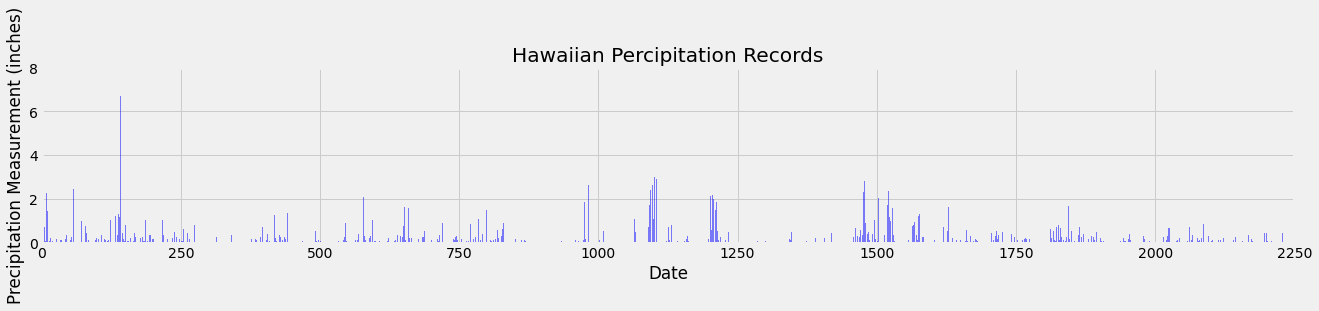

In [51]:
##############work out tick location issue#################

# Use Pandas Plotting with Matplotlib to plot the data 
# Set x axis and tick locations
x_axis = np.arange(len(sorted_prcp))
tick_locations = [value for value in x_axis]

# Create a list indicating where to write x labels and set figure size to adjust for space
plt.figure(figsize=(20,3))
plt.bar(x_axis, sorted_prcp["prcp"], color='b', alpha=0.5, align="center")
plt.xlim(0, 2250)
plt.ylim(0, 8)

plt.title("Hawaiian Percipitation Records")
plt.xlabel("Date")
plt.ylabel("Precipitation Measurement (inches)")  

#plt.xticks(tick_locations, rotation="vertical")

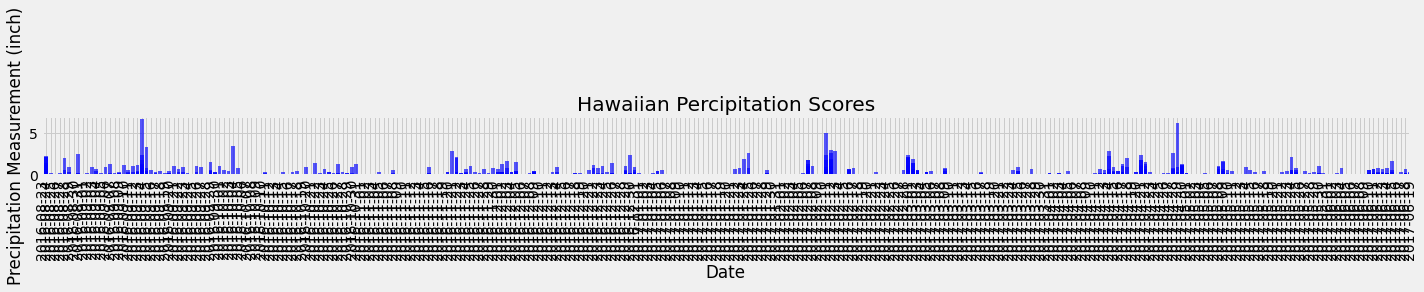

In [31]:
#################FIX GRAPH LAYOUT Tick size############################################
# Use Pandas Plotting with Matplotlib to plot the data
date = sorted_prcp.index.values
rain = sorted_prcp["prcp"]

plt.figure(figsize=(20,3))
plt.bar(date, rain, color='b', alpha=0.65, align="center")
plt.xlim(0, 300)
plt.ylim(0,7)

plt.xticks(rotation=90)
plt.title("Hawaiian Percipitation Scores")
plt.xlabel("Date")
plt.ylabel("Precipitation Measurement (inch)")  
plt.tight_layout()
plt.show()

In [ ]:
##################GO BACK TO ROUND OFF DECIMALS#########################

# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_mean = sorted_prcp["prcp"].mean()
prcp_median = sorted_prcp["prcp"].median()
prcp_var = sorted_prcp["prcp"].var()
prcp_stdev = sorted_prcp["prcp"].std()
prcp_min = sorted_prcp["prcp"].min()
prcp_max = sorted_prcp["prcp"].max()

print(f'Precipitation statistics for Hawaii mean {prcp_mean}, median {prcp_median}, variance {prcp_var}, .\
standard deviation {prcp_stdev}, minimum {prcp_min} inches, and maximum {prcp_max} inches')

# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(station).count()
print(station_count)

####alternative code using measurement table to identify unique stations
unique_number = session.query(measurement).group_by(measurement.station).count()
print(unique_number)

In [ ]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
unique_stations = session.query(measurement.station, func.count(measurement.station)).\
group_by(measurement.station).all() 
print(unique_stations)

# List the stations and the counts in descending order by creating a unique station df then sorting
unique_df = pd.DataFrame({
    "Stations" : ["USC00511918","USC00513117","USC00514830", "USC00516128", "USC00517948","USC00518838",\
                 "USC00519281", "USC00519397", "USC00519523"],
    "Frequency" : [1971, 2709, 2202, 2612, 1372, 511, 2772, 2724, 2669]})
    
sorted_unique_df = unique_df.sort_values(by=['Frequency'], ascending=False)
sorted_unique_df

In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#Create for all station data then filter by most frequent USC00519281
temperature = [measurement.id,
             measurement.station,
             measurement.date,
             measurement.prcp,
             measurement.tobs]

station_temp = session.query(*temperature)
station_temp_df = pd.DataFrame(station_temp, columns=['id', 'station', 'date', 'prcp', 'temp'])
station_temp_df.set_index('id', inplace=True)
station_temp_df

waihee_station = station_temp_df.loc[station_temp_df["station"]=="USC00519281"]
waihee_station.head()

In [ ]:
#Calculate the lowest, highest, and average temperature for most frequently reporting station USC00519281.
temp_min = waihee_station["temp"].min()
temp_max = waihee_station["temp"].max()
temp_avg = waihee_station["temp"].mean()
print(f'Waihee station minimum temp is {temp_min}F, the maximum temp is {temp_max}, and the average temp is {temp_avg}F')

In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#query the database for the most recent year and filter by most active station USC00519281
annualized = session.query(*precipitation).\
filter(measurement.date > '2016-08-23').\
filter(measurement.date < '2017-08-23').\
filter(measurement.station == "USC00519281").all()
annualized
                                  
#Create a dataframe from filtered query
waihee_annual = pd.DataFrame(annualized, columns=['id', 'station', 'date', 'prcp', 'temp'])
waihee_annual.set_index('id', inplace=True)
waihee_annual

In [ ]:
#plot the data in a historgram
temperature = waihee_annual["temp"]
plt.hist(temperature)
plt.title("Temperature Recordings fro Waihee Station")
plt.xlabel('Temperature (°F)')
plt.ylabel("Count of Recordings")
plt.show()

# Close session

In [ ]:
# Close Session
session.close()